In [ ]:
import numpy as np
import torch; torch.set_default_dtype(torch.float32)
import torch.nn as nn
import torch.optim as optim
import copy
import pickle as pkl
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

device = 'mps'
torch.set_default_device(device)
device = torch.device(f'{device}:0')

In [ ]:
#%cd ~/Desktop
!wget https://dsd.seas.upenn.edu/wp-content/uploads/2023/03/Lab3Data.zip
!unzip Lab3Data.zip

--2024-03-20 12:51:45--  https://dsd.seas.upenn.edu/wp-content/uploads/2023/03/Lab3Data.zip
Resolving dsd.seas.upenn.edu (dsd.seas.upenn.edu)... 158.130.67.172
Connecting to dsd.seas.upenn.edu (dsd.seas.upenn.edu)|158.130.67.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 590792 (577K) [application/zip]
Saving to: ‘Lab3Data.zip.3’

Lab3Data.zip.3      100%[===================>] 576.95K  3.20MB/s    in 0.2s    

2024-03-20 12:51:45 (3.20 MB/s) - ‘Lab3Data.zip.3’ saved [590792/590792]

Archive:  Lab3Data.zip
replace movie_data.p? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# The following command loads the data. For this to work the file "movie_data.p"
# must be uploaded to this notebook. To do that, navigate to the Jupyter Notebook
# interface home page and use the “Upload” option.
contents = pkl.load(open("movie_data.p","rb"))
data = contents['data']

# The data file contains a graph of movie similarities. The graph has P nodes.
# This is the graph we will use to run the GNN.
S = data['S'].to(torch.float32).to(device)
P = S.shape[0]

# The data file contains a training set with entries (x_n, y_n, p_n).
# These entries are stored in the arrays xTrain, yTrain, and pTrain,
# respectively. All of these arrays have nTrain columns, with each
# column corresponding to a different entry in the dataset.
xTrain = data['train']['x'].to(torch.float32).to(device) # Available ratings for making predictions.
yTrain = data['train']['y'].to(torch.float32).to(device) # Rating to be predicted
pTrain = data['train']['p'].to(device) # Index of the movie whose rating is being predicted
nTrain = xTrain.shape[0]

# Same thing with test data
xTest = data['test']['x'].to(torch.float32).to(device)
yTest = data['test']['y'].to(torch.float32).to(device)
pTest = data['test']['p'].to(device)
nTest = xTest.shape[0]

NotImplementedError: Could not run 'aten::empty_strided' with arguments from the 'MPS' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::empty_strided' is only available for these backends: [CPU, CUDA, Meta, QuantizedCPU, QuantizedCUDA, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradHIP, AutogradXLA, AutogradMPS, AutogradIPU, AutogradXPU, AutogradHPU, AutogradVE, AutogradLazy, AutogradMTIA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, AutogradMeta, AutogradNestedTensor, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

CPU: registered at aten/src/ATen/RegisterCPU.cpp:31357 [kernel]
CUDA: registered at aten/src/ATen/RegisterCUDA.cpp:44411 [kernel]
Meta: registered at aten/src/ATen/RegisterMeta.cpp:26984 [kernel]
QuantizedCPU: registered at aten/src/ATen/RegisterQuantizedCPU.cpp:944 [kernel]
QuantizedCUDA: registered at aten/src/ATen/RegisterQuantizedCUDA.cpp:459 [kernel]
BackendSelect: registered at aten/src/ATen/RegisterBackendSelect.cpp:807 [kernel]
Python: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:154 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:498 [backend fallback]
Functionalize: registered at ../aten/src/ATen/FunctionalizeFallbackKernel.cpp:324 [backend fallback]
Named: registered at ../aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: fallthrough registered at ../aten/src/ATen/ConjugateFallback.cpp:21 [kernel]
Negative: fallthrough registered at ../aten/src/ATen/native/NegateFallback.cpp:23 [kernel]
ZeroTensor: fallthrough registered at ../aten/src/ATen/ZeroTensorFallback.cpp:90 [kernel]
ADInplaceOrView: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:86 [backend fallback]
AutogradOther: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradCPU: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradCUDA: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradHIP: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradXLA: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradMPS: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradIPU: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradXPU: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradHPU: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradVE: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradLazy: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradMTIA: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradPrivateUse1: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradPrivateUse2: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradPrivateUse3: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradMeta: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradNestedTensor: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
Tracer: registered at ../torch/csrc/autograd/generated/TraceType_2.cpp:17346 [kernel]
AutocastCPU: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:378 [backend fallback]
AutocastCUDA: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:244 [backend fallback]
FuncTorchBatched: registered at ../aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:720 [backend fallback]
BatchedNestedTensor: registered at ../aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:746 [backend fallback]
FuncTorchVmapMode: fallthrough registered at ../aten/src/ATen/functorch/VmapModeRegistrations.cpp:28 [backend fallback]
Batched: registered at ../aten/src/ATen/LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at ../aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at ../aten/src/ATen/functorch/TensorWrapper.cpp:203 [backend fallback]
PythonTLSSnapshot: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:162 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:494 [backend fallback]
PreDispatch: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:166 [backend fallback]
PythonDispatcher: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:158 [backend fallback]


In [ ]:
def movieMSELoss(yHat, y, idxMovie):
    """
    evaluates the square of comparing yHat(p) with y. The function
    accepts as an input tensors with multiple movie ratings.
    Inputs:
      yHat: torch.Tensor (NumUsers x 1 x NumMovies)
        A set of rating estimates. It includes estimates of all movies.
      y: torch.Tensor (NumUsers x 1)
        A specific rating of a specific movie
      idxMovie: torch.Tensor
        The index of the movie whose rating is given by y

    Outputs:
      mse: jnp.ndarray
        Computed mean squared error.

    """
    # the .squeeze() method is needed for dimension match between y and yHat
    yHat = yHat.squeeze()
    # Isolate the predictions in yHat that we will use for comparison
    prediction = yHat[:,idxMovie]
    return torch.mean((prediction-y)**2)

In [ ]:
def FilterFunction(x, h, S, b):
    '''
    The following function defines a Graph Filter.
    Inputs:
      x: Input to Graph Filter
      h: Filter
      S: Graph Shift Operator
      b: Bias term

      Outpus:
      y: Output of Graph Filter
    '''
    # X is  B x G x N
    # S is NxN
    B, G, N = x.shape
    K, _, F = h.shape
    y = torch.zeros((B, N, F), device=device)
    # The following for-loop is utilized to perform the graph diffusions
    for k in range(K):
        # sum S^k x * h_k
        # We permute x dimensions it to get dimensions B x N x G
        # The filter has dimensions G x F
        y += torch.matmul(x.permute((0,2,1)), h[k])
        # diffuse signal
        x = torch.matmul(x, S)
    # y has dims B x N x F,
    # add bias of shape F
    y = y + b.to(device)
    # permute dimensions to get the desired dimensions B x F x N
    y = y.permute(0, 2, 1)
    return  y

In [ ]:
class FilterModule(nn.Module):
    #First we initialize the graph filter class and define the attributes
    def __init__(self, k, f_in, f_out):
        """
        initialize graph filter
        :param k: order of the filter
        :param f_in: filter input dimension
        :param f_out:  filter output dimension
        """
        super().__init__()
        self.k     = k
        self.f_in  = f_in
        self.f_out = f_out
        # initialize weights and bias
        self.bias = nn.parameter.Parameter(torch.Tensor(self.f_out))
        self.h = nn.Parameter(torch.randn(self.k, self.f_in, self.f_out))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.f_in * self.k)
        self.h.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, x, S):
        """
        PyTorch module interface implementation; just apply the filter
        """
        return FilterFunction(x, self.h, S, self.bias)

class GraphFilter(nn.Module):
  def __init__(self, k, f):
        """
        initialize graph filter
        :param k: order of the filters
        :param f: number of filters
        """
        super().__init__()
        self.k = k
        self.f = f
        # one input feature, f filter outputs
        self.filter_bank = FilterModule(self.k, 1, self.f)
        # add last linear layer, output dim=1
        self.readout = FilterModule(1, self.f, 1)
  def forward(self, x, S):
    x = self.filter_bank(x, S)
    return self.readout(x, S)

class GNN(nn.Module):
  def __init__(self, K, F):
        """
        initialize graph filter
        :param k: order of the filters
        :param f: number of filters
        """
        super().__init__()
        self.K = K
        self.F = F
        self.relu = torch.nn.ReLU()
        assert len(K) + 1 == len(F)
        assert F[0] == 1
        assert F[-1] == 1
        # one input feature, f filter outputs
        self.filter_bank = nn.ModuleList()
        for i in range(len(K)):
          filter = FilterModule(self.K[i], self.F[i], self.F[i+1])
          self.filter_bank.append(filter)
  def forward(self, x, S):
    for i in range(len(self.filter_bank)):
      x = self.filter_bank[i](x, S)
      x = self.relu(x)
    return x

In [ ]:
K = [10, 10, 5, 1]
F = [1, 128, 64, 32, 1]
model = GNN(K, F)

In [ ]:
nEpochs = 15
learningRate = 0.01
batchSize = 20

optimizer = optim.Adam(model.parameters(), lr=learningRate)
batchIndex = np.append(np.arange(0, nTrain, batchSize), nTrain)
nBatches = int(np.ceil(nTrain/batchSize))

In [ ]:
lossTrain = []
lossTest = []
for epoch in range(nEpochs):
    randomPermutation = np.random.permutation(nTrain)
    idxEpoch = [int(i) for i in randomPermutation]
    epoch_loss=0
    for batch in tqdm(range(nBatches)):
        # Determine batch indices
        thisBatchIndices = idxEpoch[batchIndex[batch]
                                    : batchIndex[batch+1]]

        # Get the samples in this batch
        xTrainBatch = xTrain[thisBatchIndices,:,:]
        yTrainBatch = yTrain[thisBatchIndices]
        pTrainBatch = pTrain[thisBatchIndices]
        model.zero_grad()
        # Obtain the output of the architectures
        yHatTrainBatch = model(xTrainBatch, S)
        # Compute loss
        lossValueTrain = movieMSELoss(yHatTrainBatch, yTrainBatch, pTrainBatch)
        # Compute gradients
        lossValueTrain.backward()

        # Update parameters
        optimizer.step()

        #accumulate loss
        epoch_loss+=lossValueTrain.item()
        lossTrain.append(lossValueTrain.item())

        # Now compute the test loss
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # No need to track gradients
            # Assuming your test data is xTest, yTest, and pTest
            yHatTest = model(xTest, S)
            test_loss = movieMSELoss(yHatTest, yTest, pTest).item()  # Compute test loss
            lossTest.append(test_loss)  # Store test loss
    print(f"Epoch: {epoch+1} \t Loss: {epoch_loss/nBatches:.2f} \n")

100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 17.02it/s]


Epoch: 1 	 Loss: 1.89 



100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 16.90it/s]


Epoch: 2 	 Loss: 1.08 



100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 16.90it/s]


Epoch: 3 	 Loss: 1.11 



100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 16.97it/s]


Epoch: 4 	 Loss: 1.06 



100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 16.84it/s]


Epoch: 5 	 Loss: 1.04 



100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 17.09it/s]


Epoch: 6 	 Loss: 1.05 



100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 16.83it/s]


Epoch: 7 	 Loss: 1.04 



100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 17.12it/s]


Epoch: 8 	 Loss: 1.05 



100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 16.59it/s]


Epoch: 9 	 Loss: 1.06 



100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 16.76it/s]


Epoch: 10 	 Loss: 1.03 



100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 16.67it/s]


Epoch: 11 	 Loss: 1.06 



100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 17.01it/s]


Epoch: 12 	 Loss: 1.04 



100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 17.25it/s]


Epoch: 13 	 Loss: 1.10 



100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 17.08it/s]


Epoch: 14 	 Loss: 1.04 



100%|█████████████████████████████████████████| 138/138 [00:08<00:00, 17.11it/s]

Epoch: 15 	 Loss: 1.03 



Final Training Loss: 1.00
Final Test Loss: 0.88


Text(0.5, 1.0, 'Graph Filter Training and Test Loss Evolution')

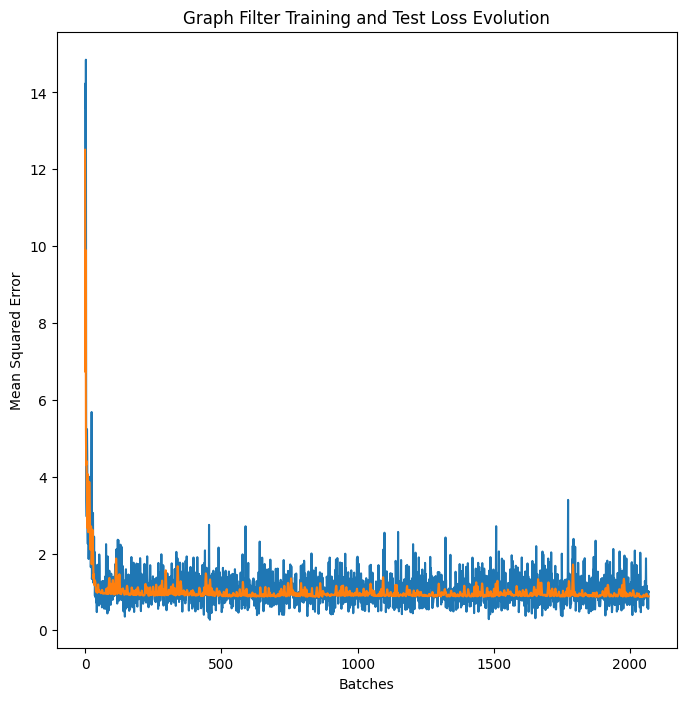

In [ ]:
yHatTest = model(xTest, S)
testMSE = movieMSELoss(yHatTest, yTest, pTest)

print(f"Final Training Loss: {lossTrain[-1]:.2f}")
print(f"Final Test Loss: {lossTest[-1]:.2f}")
plt.figure(figsize = (8,8))
plt.plot(lossTrain, label = 'Train MSE')
plt.plot(lossTest, label = 'Test MSE')
plt.ylabel('Mean Squared Error')
plt.xlabel('Batches')
plt.title('Graph Filter Training and Test Loss Evolution')